# Curriculum Learning

In [7]:
!pip install git+https://github.com/murraylab/PsychRNN


  Cloning https://github.com/murraylab/PsychRNN to /tmp/pip-req-build-tun5oeub
  Running command git clone --filter=blob:none --quiet https://github.com/murraylab/PsychRNN /tmp/pip-req-build-tun5oeub
  Resolved https://github.com/murraylab/PsychRNN to commit aff98e119d6f0ac780196ec50cc7166509d3938f
  Preparing metadata (setup.py) ... done


Notebook ready. Run cells to perform training.


In [ ]:

import os, math, json, random, time
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from tqdm.notebook import trange, tqdm

import torch
import torch.nn as nn
import torch.optim as optim
# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


In [ ]:
# We generate 2-channel inputs: evidence for left and right. On a trial, the "true" choice
# is either 0 or 1. If choice == 0 (left), we add +coherence to channel 0 and 0 to channel 1
# (or the opposite sign). We add gaussian noise each time step. The network must choose at final time.

def generate_batch(batch_size, T, coherence, stim_std=1.0, input_dim=2, decision_time=None):
    """
    Returns:
      x : tensor float (batch, T, input_dim)
      y : tensor long (batch,) labels 0 or 1
      mask : (not used here but kept for API parity)
    """
    if decision_time is None:
        decision_time = T  # decision at final time step

    # randomly pick labels 0 or 1
    labels = np.random.choice([0,1], size=(batch_size,))
    x = np.random.randn(batch_size, T, input_dim) * stim_std
    for i, lab in enumerate(labels):
        x[i, :, lab] += coherence
    x_t = torch.tensor(x, dtype=torch.float32, device=device)
    y_t = torch.tensor(labels, dtype=torch.long, device=device)
    return x_t, y_t


In [ ]:
class SimpleRNN(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=80, output_dim=2, rec_noise_std=0.0):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.rec_noise_std = rec_noise_std
        self.W_in = nn.Linear(input_dim, hidden_dim, bias=True)
        self.W_rec = nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.out = nn.Linear(hidden_dim, output_dim, bias=True)
        self.activation = torch.tanh

    def forward(self, x, return_hidden=False):
        # x: (batch, T, input_dim)
        batch, T, _ = x.size()
        h = torch.zeros(batch, self.hidden_dim, device=x.device)
        hs = []
        for t in range(T):
            xt = x[:, t, :]
            h = self.activation(self.W_in(xt) + self.W_rec(h))
            if self.rec_noise_std and self.training:
                h = h + torch.randn_like(h) * self.rec_noise_std
            hs.append(h.unsqueeze(1))
        hs = torch.cat(hs, dim=1)  # (batch, T, hidden_dim)
        logits = self.out(hs[:, -1, :])  # take last time step
        if return_hidden:
            return logits, hs
        return logits


In [ ]:
import torch.nn.functional as F

def compute_accuracy(model, coherence, n_trials=256, batch_size=64, T=40, stim_std=1.0):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        while total < n_trials:
            b = min(batch_size, n_trials - total)
            x, y = generate_batch(b, T, coherence, stim_std=stim_std)
            logits = model(x)  # (b, 2)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += b
    return correct / total

def psychometric_curve(model, coherences, n_trials_each=300, batch_size=64, T=40, stim_std=1.0):
    accs = []
    for c in coherences:
        acc = compute_accuracy(model, c, n_trials=n_trials_each, batch_size=batch_size, T=T, stim_std=stim_std)
        accs.append(acc)
    return np.array(accs)

def pca_trajectory(model, coherence, T=40):
    model.eval()
    with torch.no_grad():
        x, y = generate_batch(1, T, coherence)
        _, hs = model(x, return_hidden=True)  # (1, T, hidden)
        h = hs[0].cpu().numpy()  # T x hidden
    pca = PCA(n_components=3)
    traj = pca.fit_transform(h)
    return traj, y.cpu().numpy()[0], pca.explained_variance_ratio_


In [ ]:
def train_with_curriculum(
    seed=0,
    training_iters=2000,
    batch_size=64,
    T=40,
    hidden_dim=80,
    lr=1e-3,
    rec_noise_std=0.0,
    start_coh=0.6,
    min_coh=0.1,
    coh_step=0.1,
    eval_interval=200,
    target_acc=0.8,
    outdir="out_curriculum",
    verbose=True
):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    os.makedirs(outdir, exist_ok=True)
    model = SimpleRNN(input_dim=2, hidden_dim=hidden_dim, output_dim=2, rec_noise_std=rec_noise_std).to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    losses = []
    eval_coherences = [0.05, 0.1, 0.2, 0.4, 0.6, 0.8]
    psych_history = []
    coher = start_coh

    # helper to evaluate on validation set at current coherence
    def eval_val_acc():
        return compute_accuracy(model, coher, n_trials=256, batch_size=batch_size, T=T)

    # training loop
    it = 0
    last_print = time.time()
    while it < training_iters:
        model.train()
        x, y = generate_batch(batch_size, T, coher)
        opt.zero_grad()
        logits = model(x)
        loss = loss_fn(logits, y)
        loss.backward()
        opt.step()

        losses.append(loss.item())
        it += 1

        if it % eval_interval == 0:
            val_acc = eval_val_acc()
            psych = psychometric_curve(model, eval_coherences, n_trials_each=200, batch_size=batch_size, T=T)
            psych_history.append((it, coher, val_acc, psych))
            if verbose:
                print(f"iter {it:5d} | coh {coher:.2f} | loss {loss.item():.4f} | val_acc {val_acc:.3f}")
            # curriculum step
            if val_acc >= target_acc and coher - coh_step >= min_coh:
                coher = max(min_coh, coher - coh_step)
                if verbose:
                    print(f"  -> Curriculum: lowered coherence to {coher:.2f} at iter {it}")
    # final evaluation psychometric
    final_psych = psychometric_curve(model, eval_coherences, n_trials_each=500, batch_size=batch_size, T=T)
    # save artifacts
    # convert psych_history elements to lists before saving
    psych_history_serializable = []
    for it, coh, val_acc, psych in psych_history:
        psych_history_serializable.append({
            "iteration": int(it),
            "coherence": float(coh),
            "val_acc": float(val_acc),
            "psych": np.array(psych).tolist()
        })

    results = {
        "losses": [float(x) for x in losses],
        "psych_history": psych_history_serializable,
        "final_psych": np.array(final_psych).tolist(),
        "eval_coherences": list(map(float, eval_coherences)),
        "params": {
            "seed": int(seed), "training_iters": int(training_iters), "batch_size": int(batch_size),
            "T": int(T), "hidden_dim": int(hidden_dim), "lr": float(lr),
            "rec_noise_std": float(rec_noise_std), "start_coh": float(start_coh),
            "min_coh": float(min_coh), "coh_step": float(coh_step), "target_acc": float(target_acc)
        }
    }

    torch.save(model.state_dict(), os.path.join(outdir, "model_state.pt"))
    with open(os.path.join(outdir, "results.json"), "w") as f:
        json.dump(results, f, indent=2)

    # return model and results
    return model, results


In [ ]:
OUT = Path("out_curriculum_demo")
OUT.mkdir(exist_ok=True)

experiments = {
    "baseline": {"rec_noise_std": 0.0, "start_coh": 0.2, "mode":"baseline"},
    "noisy": {"rec_noise_std": 0.1, "start_coh": 0.2, "mode":"noisy"},
    "curriculum": {"rec_noise_std": 0.0, "start_coh": 0.6, "mode":"curriculum"},
}

models = {}
results = {}

for name, cfg in experiments.items():
    print("=== Running", name)
    outdir = OUT / name
    m, res = train_with_curriculum(
        seed=0,
        training_iters=5000,       # quick demo; increase for final
        batch_size=64,
        T=40,
        hidden_dim=80,
        lr=1e-3,
        rec_noise_std=cfg["rec_noise_std"],
        start_coh=cfg["start_coh"],
        min_coh=0.1,
        coh_step=0.1,
        eval_interval=200,
        target_acc=0.80,
        outdir=str(outdir),
        verbose=True
    )
    models[name] = m
    results[name] = res
    print("Saved results to", outdir)


=== Running baseline
iter   200 | coh 0.20 | loss 0.4094 | val_acc 0.820
  -> Curriculum: lowered coherence to 0.10 at iter 200
iter   400 | coh 0.10 | loss 0.6200 | val_acc 0.688
iter   600 | coh 0.10 | loss 0.7020 | val_acc 0.660
iter   800 | coh 0.10 | loss 0.6903 | val_acc 0.645
iter  1000 | coh 0.10 | loss 0.6343 | val_acc 0.602
iter  1200 | coh 0.10 | loss 0.5644 | val_acc 0.594
iter  1400 | coh 0.10 | loss 0.6916 | val_acc 0.652
iter  1600 | coh 0.10 | loss 0.5808 | val_acc 0.621
iter  1800 | coh 0.10 | loss 0.7120 | val_acc 0.629
iter  2000 | coh 0.10 | loss 0.5999 | val_acc 0.664
iter  2200 | coh 0.10 | loss 0.5927 | val_acc 0.656
iter  2400 | coh 0.10 | loss 0.6125 | val_acc 0.641
iter  2600 | coh 0.10 | loss 0.5995 | val_acc 0.668
iter  2800 | coh 0.10 | loss 0.6251 | val_acc 0.652
iter  3000 | coh 0.10 | loss 0.6637 | val_acc 0.590
iter  3200 | coh 0.10 | loss 0.6442 | val_acc 0.602
iter  3400 | coh 0.10 | loss 0.5562 | val_acc 0.664
iter  3600 | coh 0.10 | loss 0.6564 | va

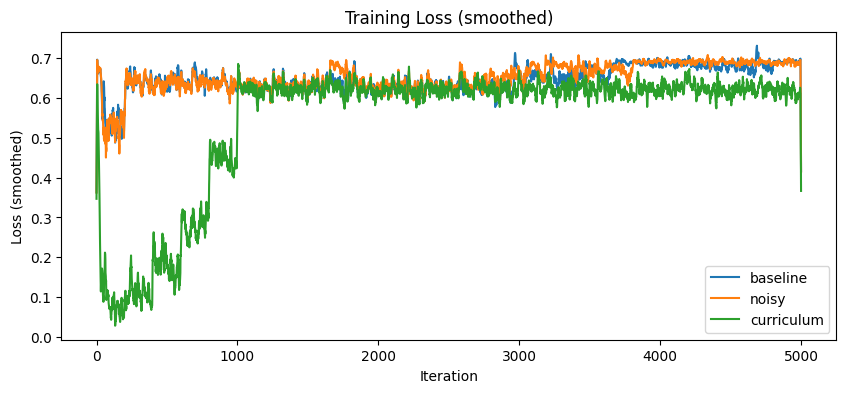

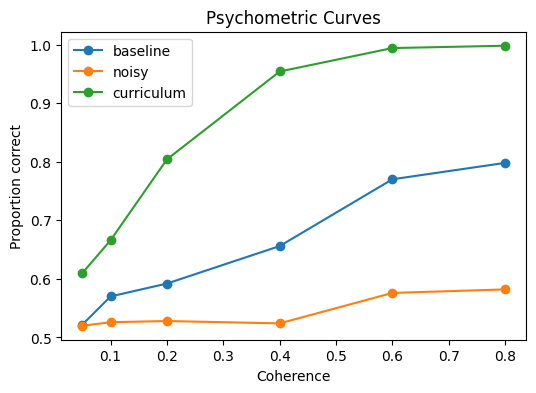

In [ ]:
plt.figure(figsize=(10,4))
for name, res in results.items():
    losses = res["losses"]
    plt.plot(np.convolve(losses, np.ones(10)/10, mode='same'), label=name)
plt.xlabel("Iteration"); plt.ylabel("Loss (smoothed)"); plt.legend(); plt.title("Training Loss (smoothed)")
plt.savefig(OUT / "loss_curves.png", dpi=150)
plt.show()

# psychometric curves
plt.figure(figsize=(6,4))
coh = results["baseline"]["eval_coherences"]
for name, res in results.items():
    psych = np.array(res["final_psych"])
    plt.plot(coh, psych, '-o', label=name)
plt.xlabel("Coherence"); plt.ylabel("Proportion correct"); plt.title("Psychometric Curves")
plt.legend()
plt.savefig(OUT / "psych_curves.png", dpi=150)
plt.show()


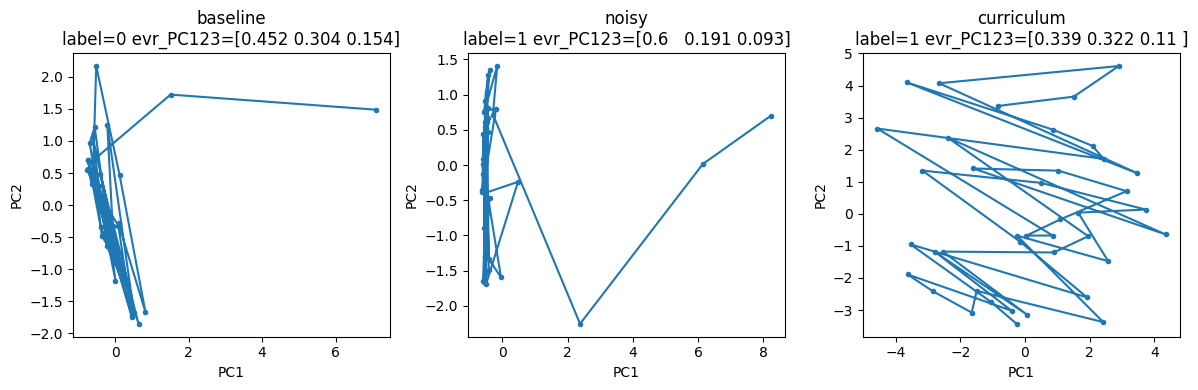

In [33]:
# Cell 9 - PCA trajectories for one representative trial from each model
plt.figure(figsize=(12,4))
for i,(name, model) in enumerate(models.items()):
    traj, lab, evr = pca_trajectory(model, coherence=0.4, T=40)
    ax = plt.subplot(1,3,i+1)
    ax.plot(traj[:,0], traj[:,1], '-o', markersize=3)
    ax.set_title(f"{name}\nlabel={lab} evr_PC123={evr[:3].round(3)}")
    ax.set_xlabel("PC1"); ax.set_ylabel("PC2")
plt.tight_layout()
plt.savefig(OUT / "pca_trajectories.png", dpi=150)
plt.show()


In [ ]:
summary_lines = []
for name,res in results.items():
    final_psych = np.array(res["final_psych"])
    coherences = np.array(res["eval_coherences"])
    try:
        idx = np.where(final_psych >= 0.75)[0]
        if len(idx) == 0:
            thr = np.nan
        else:
            thr = coherences[idx[0]]
    except:
        thr = np.nan
    summary_lines.append(f"{name}: final psych (coherences {coherences.tolist()}) -> {final_psych.round(3).tolist()}, approx 75%-threshold = {thr}")
summary_text = "\n".join(summary_lines)
print("SUMMARY\n", summary_text)
(OUT/"results_summary.txt").write_text(summary_text)
print("Saved summary to", OUT/"results_summary.txt")


SUMMARY
 baseline: final psych (coherences [0.05, 0.1, 0.2, 0.4, 0.6, 0.8]) -> [0.522, 0.57, 0.592, 0.656, 0.77, 0.798], approx 75%-threshold = 0.6
noisy: final psych (coherences [0.05, 0.1, 0.2, 0.4, 0.6, 0.8]) -> [0.52, 0.526, 0.528, 0.524, 0.576, 0.582], approx 75%-threshold = nan
curriculum: final psych (coherences [0.05, 0.1, 0.2, 0.4, 0.6, 0.8]) -> [0.61, 0.666, 0.804, 0.954, 0.994, 0.998], approx 75%-threshold = 0.2
Saved summary to out_curriculum_demo/results_summary.txt
